In [1]:
# Uncomment and run the following lines if the packages are not already installed
#!pip install transformers torch matplotlib tqdm datasets scipy accelerate catppuccin
#!wget https://github.com/hallucinomeny/hyperobject/blob/main/prompts.csv
#!pip install flash_attn
# %pip install seaborn

In [2]:
from typing import List, Tuple

import os
import time
import psutil
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import csv
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import hashlib
import catppuccin
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import random
torch.cuda.empty_cache()
from torch.nn import functional as F
import torch.distributed as dist
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from datasets import load_dataset
from typing import List, Optional
import pandas as pd
import jax.numpy as jnp

In [3]:
%matplotlib inline

In [4]:

# Configuration
MODEL_NAMES = [
    # "deepseek-ai/DeepSeek-V2.5",  # Example model; replace with your target models
    "meta-llama/Llama-3.1-70B-Instruct",
    "meta-llama/Llama-3.1-70B",
    # "meta-llama/Llama-3.2-1B-Instruct",
    # "Qwen/Qwen2.5-72B-Instruct",
    # "meta-llama/Llama-3.1-8B-Instruct",
    # "meta-llama/Meta-Llama-3-8B",
]
PROMPTS_CSV_PATH = 'prompts.csv'   # Ensure this file is uploaded to Colab
MAX_PROMPTS = 16         # Number of prompts to process initially
NUM_SAMPLES = 16        # ANumber of sampleas per prompt
MAX_NEW_TOKENS = 128           # Number of tokens to generate per sample
BATCH_SIZE = 64 # Batch size for generation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hugging Face Token (if required)
HF_TOKEN = "INSERT TOKEN HERE"   # Set this as an environment variable in Colab


mpl.style.use(["ggplot", catppuccin.PALETTE.mocha.identifier])
# Setup Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [5]:
def download_and_process_dataset(
    dataset_name: str,
    text_column: str,
    split: str = "train",
    num_samples: int = 1000,
    num_prompts: Optional[int] = None,
    min_length: int = 50,
    max_length: int = 200,
    seed: int = 42,
    cache_dir: str = "./cache"
) -> List[str]:
    """
    Download a subset of a dataset from Hugging Face, process it into a list of prompts, and cache the result.
    """
    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)

    # Create a unique cache file name based on function parameters
    cache_params = f"{dataset_name}_{text_column}_{split}_{num_samples}_{num_prompts}_{min_length}_{max_length}_{seed}"
    cache_file = os.path.join(cache_dir, hashlib.md5(cache_params.encode()).hexdigest() + ".pkl")

    # Check if cached prompts exist
    if os.path.exists(cache_file):
        print(f"Loading cached prompts from {cache_file}")
        with open(cache_file, "rb") as f:
            return pickle.load(f)

    # Set random seed for reproducibility
    random.seed(seed)

    # Download the dataset in streaming mode
    dataset = load_dataset(dataset_name, split=split, streaming=True)
    
    # Process the texts into prompts
    prompts = []
    for i, sample in enumerate(dataset):
        if i >= num_samples:
            break
        
        text = sample[text_column]
        
        # Split the text into sentences or paragraphs
        segments = text.split('.')
        
        for segment in segments:
            segment = segment.strip()
            if min_length <= len(segment) <= max_length:
                prompts.append(segment)
    
    # Shuffle the prompts
    random.shuffle(prompts)
    
    # Limit the number of prompts if specified
    if num_prompts is not None:
        prompts = prompts[:num_prompts]
    
    # Cache the prompts
    print(f"Caching prompts to {cache_file}")
    with open(cache_file, "wb") as f:
        pickle.dump(prompts, f)
    
    return prompts


def load_model_and_tokenizer(model_name: str,token):
    """
    Loads model and tokenizer.
    """
    print(f"Starting to load model: {model_name}")
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
    print("Tokenizer loaded.")

    # Load model
    print("Starting to load model...")
    model = AutoModelForCausalLM.from_pretrained(
            model_name,
            token=token,
            torch_dtype=torch.bfloat16,  # Use half precision
            device_map="auto",  # Automatically choose the best device
        )
    print("Model loaded successfully.")

    tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer

In [6]:
def load_prompts(csv_path: str, max_prompts: int = 5) -> List[str]:
    """
    Load prompts from a CSV file. Each prompt should be in the first column.
    """
    prompts = []
    try:
        with open(csv_path, 'r', newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                if row:
                    logger.info(row)
                    prompts.append(row[0])
                if len(prompts) >= max_prompts:
                    break
        logger.info(f"Loaded {len(prompts)} prompts from {csv_path}")
    except FileNotFoundError:
        logger.error(f"File {csv_path} not found.")
    return prompts


In [7]:
def embed_and_perturb(
    model: AutoModelForCausalLM,
    token_ids: List[List[int]],
    perturbation_scale: float = 10
) -> torch.Tensor:
    """
    Embed a batch of token ID sequences and perturb the embeddings.
    """
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Convert token_ids to a tensor
    token_ids_tensor = torch.tensor(token_ids).to(model.device)

    # Get the embedding layer from the model
    embedding_tensor = model.get_input_embeddings().weight

    # Embed the token IDs
    with torch.no_grad():
        embeddings = embedding_tensor[token_ids_tensor]

    perturbation = torch.randn_like(embeddings) * perturbation_scale

    print(torch.mean(perturbation))
    # Add perturbation to embeddings
    embeddings += embeddings + perturbation 

    return embeddings

    
def compute_entropy_and_varentropy(logits: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute entropy and varentropy from logits.
    """
    probs = torch.softmax(logits, dim=-1)
    log_probs = torch.log_softmax(logits, dim=-1)
    entropy = -torch.sum(probs * log_probs, dim=-1)
    varentropy = torch.sum(probs * (entropy[...,None] + log_probs)**2, dim=-1) 
    return entropy, varentropy


def autoregressive_generate(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    initial_embeddings: torch.Tensor,
    max_new_tokens: int = 20,
    temperature: float = 1.0
) -> Tuple[List[str], torch.Tensor]:
    """
    Generate tokens autoregressively from initial embeddings and return generated texts and logits.

    Args:
        model (PreTrainedModel): The pre-trained transformer model.
        tokenizer (PreTrainedTokenizer): The tokenizer associated with the model.
        initial_embeddings (torch.Tensor): Initial embeddings of shape (batch_size, sequence_length, hidden_size).
        max_new_tokens (int): Maximum number of new tokens to generate. Default is 20.
        temperature (float): Sampling temperature. Default is 1.0.

    Returns:
        Tuple[List[str], torch.Tensor]: 
            - List of generated sequences, one for each item in the batch.
            - Tensor of shape (batch_size, max_new_tokens, vocab_size) containing the generated logits.
    """
    batch_size, seq_length, hidden_size = initial_embeddings.shape
    initial_embeddings = initial_embeddings.to(model.device)
    generated_ids = torch.full((batch_size, max_new_tokens), tokenizer.pad_token_id, device=model.device)
    all_entropies = torch.zeros((batch_size, max_new_tokens), device=model.device)
    all_varentropies = torch.zeros_like(all_entropies)
    embedding_layer = model.get_input_embeddings()

    with torch.inference_mode():
        next_token_logits = model(inputs_embeds=initial_embeddings).logits[:, -1, :]
        for i in range(max_new_tokens):
            entropies, varentropies = compute_entropy_and_varentropy(next_token_logits)
            all_entropies[...,i] = entropies
            all_varentropies[...,i] = varentropies
            next_token_logits = next_token_logits / temperature
            probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
            next_tokens = torch.multinomial(probs, num_samples=1).squeeze(1)
            generated_ids[:, i] = next_tokens
            token_embeddings = embedding_layer(next_tokens.unsqueeze(-1))
            next_token_logits =  model(inputs_embeds=token_embeddings).logits[:, -1, :]

    return all_entropies, all_varentropies

def generate_samples_and_compute_metrics(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    prompts: List[str] | torch.Tensor,
    num_samples: int = 10,
    max_new_tokens: int = 50,
    batch_size: int = 4,
    perturbation_scale: float = 10
) -> Tuple[List[float], List[float]]:
    """
    Generate multiple samples for given prompts and compute entropy and varentropy.
    """
    all_entropies = []
    all_varentropies = []
    
    if isinstance(prompts, list):
        input_ids = tokenizer(prompts, padding=True).input_ids
        input_ids = [[tokenizer.bos_token_id] + sequence for sequence in input_ids]
        # Encode prompts and obtain input embeddings
        perturbed_embeds = embed_and_perturb(model, input_ids, perturbation_scale)
    
    if isinstance(prompts,torch.Tensor):
        perturbed_embeds = prompts + torch.randn_like(prompts) * perturbation_scale

    total_batch_size = perturbed_embeds.shape[0]
    
    for i in range(0, total_batch_size, batch_size):
        # Generate statistics using the perturbed embeddings
        with torch.inference_mode():
            entropies, varentropies = autoregressive_generate(
                model=model,
                tokenizer=tokenizer,
                initial_embeddings=perturbed_embeds[i:i+batch_size],
                max_new_tokens=max_new_tokens
            )

        # Extract and accumulate entropy and varentropy values
        all_entropies.extend(entropies.flatten().cpu())
        all_varentropies.extend(varentropies.flatten().cpu())

        # Optional: Free up GPU memory if necessary
        # del perturbed_embeds, stats
        # torch.cuda.empty_cache()

    return all_entropies, all_varentropies

    


In [8]:

def plot_improved_metrics(entropies, varentropies, model_name):
    fig = plt.figure(figsize=(20, 15))
    
    # 2D Scatter plot
    ax_scatter = fig.add_subplot(221)
    xy = np.vstack([entropies, varentropies])
    z = gaussian_kde(xy)(xy)
    scatter = ax_scatter.scatter(entropies, varentropies, c=z, s=5, alpha=0.6, cmap='hot', norm=colors.LogNorm())
    plt.colorbar(scatter, ax=ax_scatter, label='Density')
    ax_scatter.set_xlabel('Entropy')
    ax_scatter.set_ylabel('Varentropy')
    ax_scatter.set_title(f'Entropy vs Varentropy for {model_name}')
    
    # # Hexbin plot
    # ax_hexbin = fig.add_subplot(222)
    # hexbin = ax_hexbin.hexbin(entropies, varentropies, gridsize=50, cmap='plasma', bins='log')
    # plt.colorbar(hexbin, ax=ax_hexbin, label='log(Count)')
    # ax_hexbin.set_xlabel('Entropy')
    # ax_hexbin.set_ylabel('Varentropy')
    # ax_hexbin.set_title(f'Hexbin Plot for {model_name}')

    
    # Joint entropy/varentropy
    # Create the joint plot with kde (Kernel Density Estimate) and filled contours
    entropies_np = np.array(entropies, dtype=float)
    varentropies_np = np.array(varentropies, dtype=float)
    # Create a DataFrame
    df = pd.DataFrame({'Entropy': entropies_np, 'Varentropy': varentropies_np})
    
    # Create the joint plot
    g = sns.jointplot(
        data=df,
        x="Entropy", y="Varentropy",
        kind="kde",
        height=6,
        cmap="Blues",
        fill=True  # This replaces the need for marginal_kws
    )
    
    # Customize the plot (optional)
    g.plot_joint(sns.kdeplot, cmap="Blues", shade=True)
    g.ax_joint.set_xlabel('Entropy')
    g.ax_joint.set_ylabel('Varentropy')
    
    plt.tight_layout()
    plt.show()

    
    # Entropy Marginal
    ax_entropy = fig.add_subplot(223)
    entropy_kde = gaussian_kde(entropies)
    entropy_range = np.linspace(min(entropies), max(entropies), 1000)
    ax_entropy.plot(entropy_range, entropy_kde(entropy_range), color='#00FFFF')
    ax_entropy.fill_between(entropy_range, entropy_kde(entropy_range), alpha=0.5, color='#00FFFF')
    ax_entropy.set_xlabel('Entropy')
    ax_entropy.set_ylabel('Density')
    ax_entropy.set_title('Entropy Marginal Distribution')
    ax_entropy.set_xscale('log')
    ax_entropy.set_yscale('log')
    
    # Varentropy Marginal
    ax_varentropy = fig.add_subplot(224)
    varentropy_kde = gaussian_kde(varentropies)
    varentropy_range = np.linspace(min(varentropies), max(varentropies), 1000)
    ax_varentropy.plot(varentropy_range, varentropy_kde(varentropy_range), color='#FF00FF')
    ax_varentropy.fill_between(varentropy_range, varentropy_kde(varentropy_range), alpha=0.5, color='#FF00FF')
    ax_varentropy.set_xlabel('Varentropy')
    ax_varentropy.set_ylabel('Density')
    ax_varentropy.set_title('Varentropy Marginal Distribution')
    ax_varentropy.set_xscale('log')
    ax_varentropy.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

def plot_3d_density(entropies, varentropies, model_name):
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    hist, xedges, yedges = np.histogram2d(entropies, varentropies, bins=50)
    xpos, ypos = np.meshgrid(xedges[:-1] + np.diff(xedges)/2, yedges[:-1] + np.diff(yedges)/2)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like(xpos)
    dx = np.diff(xedges)[0] * np.ones_like(zpos)
    dy = np.diff(yedges)[0] * np.ones_like(zpos)
    dz = hist.flatten()
    
    # Use a custom colormap for better visibility
    colors_base = plt.cm.get_cmap('plasma')(np.linspace(0, 1, 256))
    colors_base[:, 3] = np.linspace(0.3, 1, 256)  # Adjust alpha
    custom_cmap = colors.ListedColormap(colors_base)
    
    max_height = np.max(dz)
    normalized_heights = dz / max_height
    bar_colors = custom_cmap(normalized_heights)
    
    bars = ax.bar3d(xpos, ypos, zpos, dx, dy, np.log1p(dz), color=bar_colors, zsort='average', 
                    shade=True, lightsource=plt.matplotlib.colors.LightSource(azdeg=315, altdeg=45))
    
    color_map = plt.cm.ScalarMappable(cmap=custom_cmap)
    color_map.set_array(normalized_heights)
    plt.colorbar(color_map, ax=ax, label='Normalized Frequency', pad=0.1)
    
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Varentropy')
    ax.set_zlabel('Log(Frequency + 1)')
    ax.set_title(f'3D Density Plot for {model_name}')
    
    ax.view_init(elev=20, azim=45)
    plt.tight_layout()
    plt.show()


def compare_3d_density(entropies1, varentropies1, entropies2, varentropies2, model_name1, model_name2):
    fig = plt.figure(figsize=(24, 8))
    
    def plot_subplot(ax, data, title, cmap='plasma', diff=False):
        xpos, ypos, dz = data
        dx = dy = 1
        zpos = np.zeros_like(xpos)
        
        colors_base = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 256))
        colors_base[:, 3] = np.linspace(0.3, 1, 256)  # Adjust alpha
        custom_cmap = colors.ListedColormap(colors_base)
        
        if diff:
            max_abs = np.max(np.abs(dz))
            normalized_heights = (dz + max_abs) / (2 * max_abs)
        else:
            max_height = np.max(dz)
            normalized_heights = dz / max_height
        
        bar_colors = custom_cmap(normalized_heights)
        
        bars = ax.bar3d(xpos, ypos, zpos, dx, dy, dz if diff else np.log1p(dz), 
                        color=bar_colors, zsort='average', 
                        shade=True, lightsource=plt.matplotlib.colors.LightSource(azdeg=315, altdeg=45))
        
        color_map = plt.cm.ScalarMappable(cmap=custom_cmap)
        color_map.set_array(normalized_heights)
        plt.colorbar(color_map, ax=ax, label='Normalized Frequency' if not diff else 'Difference', pad=0.1)
        
        ax.set_xlabel('Entropy')
        ax.set_ylabel('Varentropy')
        ax.set_zlabel('Log(Frequency + 1)' if not diff else 'Difference')
        ax.set_title(title)
        
        ax.view_init(elev=20, azim=45)
    
    # Calculate histograms
    hist1, xedges, yedges = np.histogram2d(entropies1, varentropies1, bins=100)
    hist2, _, _ = np.histogram2d(entropies2, varentropies2, bins=[xedges, yedges])
    
    xpos, ypos = np.meshgrid(xedges[:-1] + np.diff(xedges)/2, yedges[:-1] + np.diff(yedges)/2)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    
    # Plot first histogram
    ax1 = fig.add_subplot(131, projection='3d')
    plot_subplot(ax1, (xpos, ypos, hist1.flatten()), f'3D Density Plot for {model_name1}')
    
    # Plot second histogram
    ax2 = fig.add_subplot(132, projection='3d')
    plot_subplot(ax2, (xpos, ypos, hist2.flatten()), f'3D Density Plot for {model_name2}')
    
    # Plot difference
    ax3 = fig.add_subplot(133, projection='3d')
    diff = hist2 - hist1
    plot_subplot(ax3, (xpos, ypos, diff.flatten()), f'Difference ({model_name2} - {model_name1})', 
                 cmap='coolwarm', diff=True)
    
    plt.tight_layout()
    plt.show()


2024-10-15 20:36:14,490 - INFO - Processing model: meta-llama/Llama-3.1-70B-Instruct


Loading cached prompts from ./cache/14a3198808a0c04aed8d6b594886989c.pkl
dict_keys(['meta-llama/Llama-3.1-70B-Instruct', 'meta-llama/Llama-3.1-70B'])
Starting to load model: meta-llama/Llama-3.1-70B-Instruct
Using CUDA device: NVIDIA H100 80GB HBM3
Tokenizer loaded.
Starting to load model...


2024-10-15 20:36:15,665 - INFO - Device 0 seems unavailable, Proceeding to check subsequent devices.
2024-10-15 20:36:16,825 - INFO - Device 7 seems unavailable, Proceeding to check subsequent devices.


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Model loaded successfully.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:12<00:00,  9.05s/it]
2024-10-15 20:37:56,733 - INFO - Plotting metrics for model: meta-llama/Llama-3.1-70B-Instruct
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


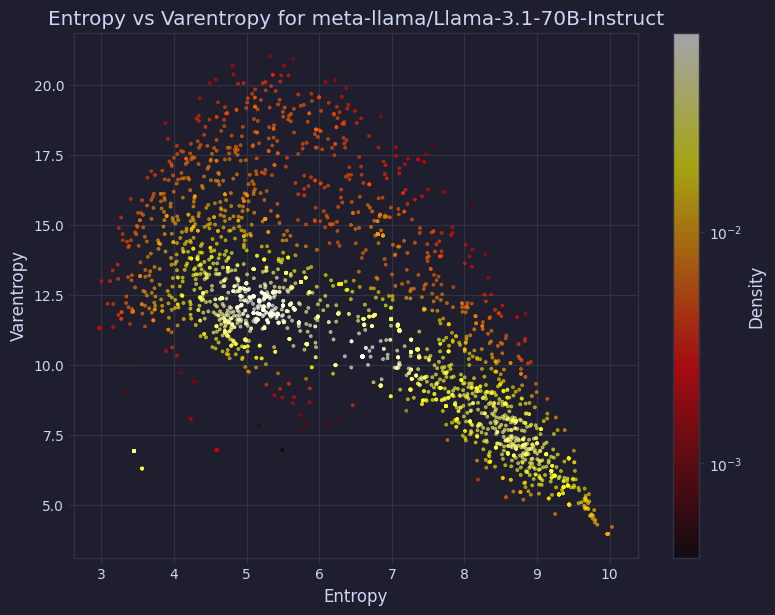

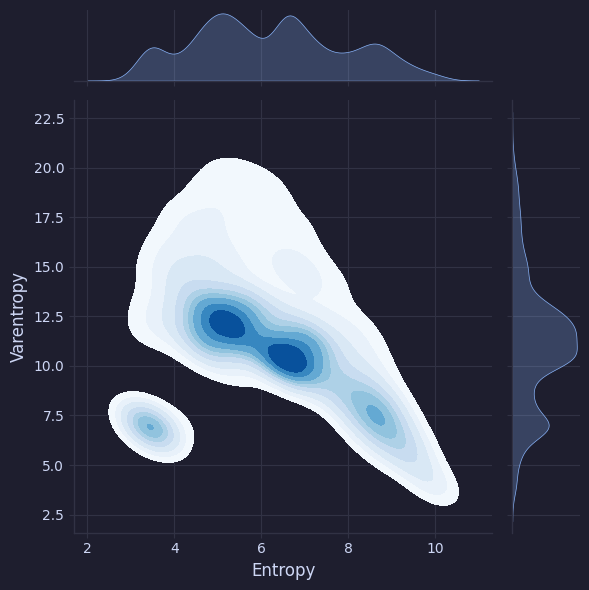

<Figure size 640x480 with 0 Axes>

2024-10-15 20:37:59,750 - INFO - Plotting 3D density for model: meta-llama/Llama-3.1-70B-Instruct
/tmp/ipykernel_497070/881148481.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_base = plt.cm.get_cmap('plasma')(np.linspace(0, 1, 256))


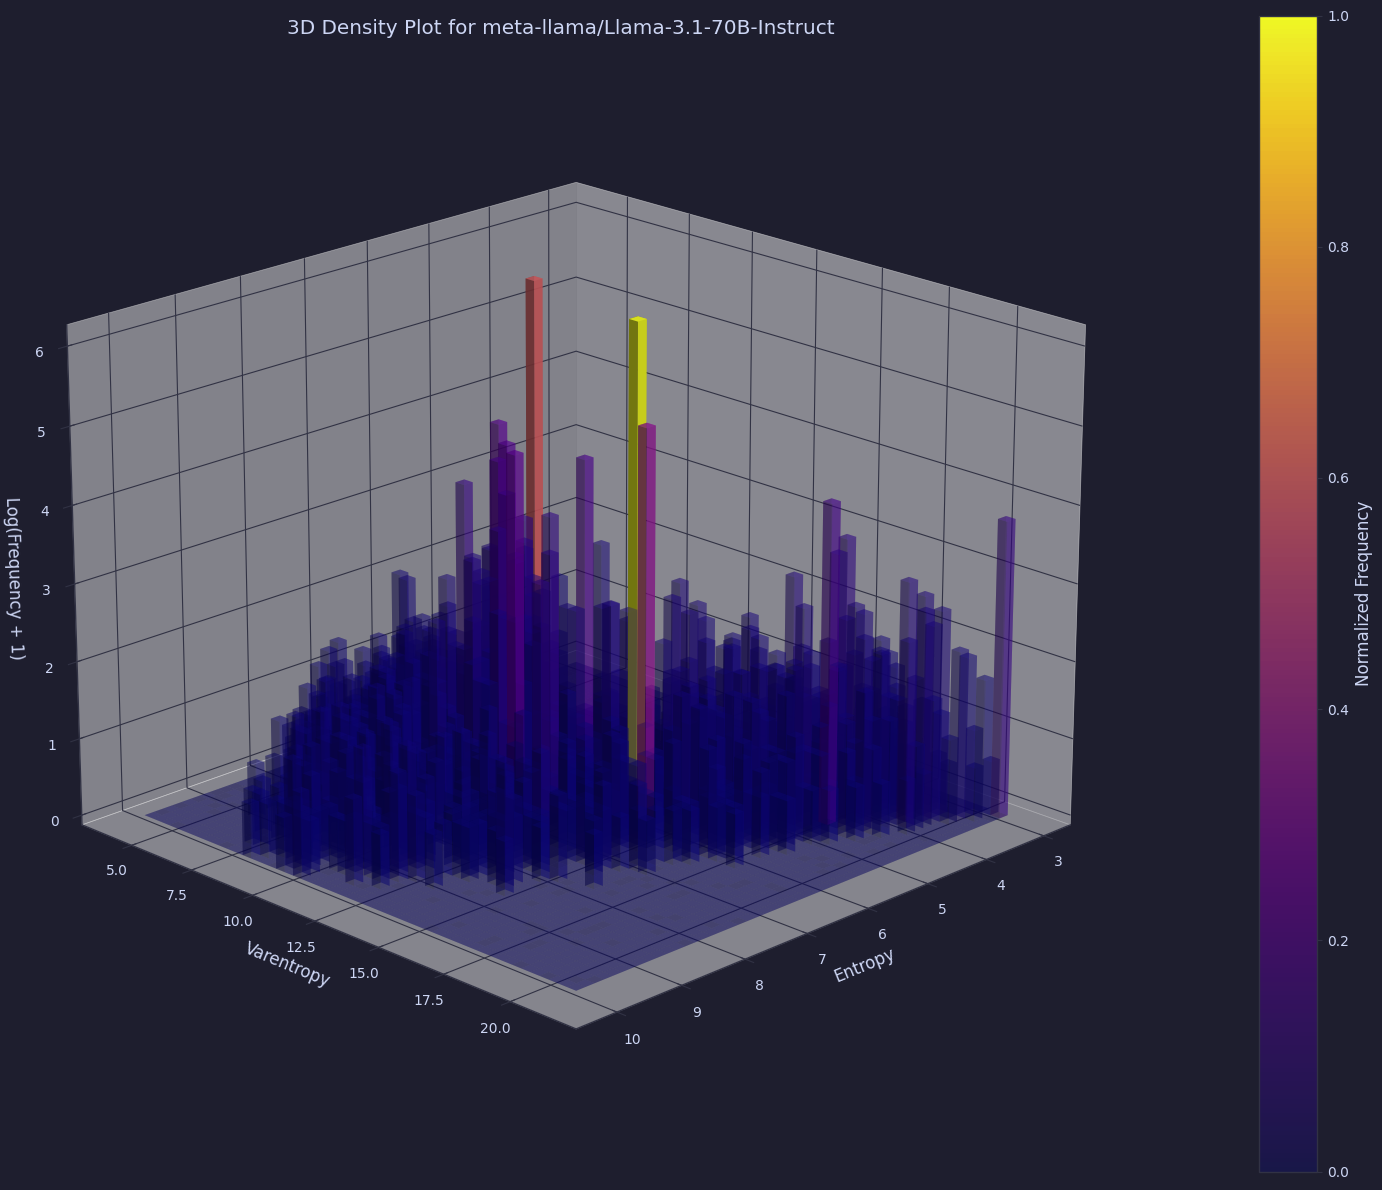

2024-10-15 20:38:00,648 - INFO - Finished processing model: meta-llama/Llama-3.1-70B-Instruct
2024-10-15 20:38:00,648 - INFO - Processing model: meta-llama/Llama-3.1-70B


Starting to load model: meta-llama/Llama-3.1-70B
Using CUDA device: NVIDIA H100 80GB HBM3
Tokenizer loaded.
Starting to load model...


2024-10-15 20:38:01,437 - INFO - Device 0 seems unavailable, Proceeding to check subsequent devices.
2024-10-15 20:38:01,651 - INFO - Device 7 seems unavailable, Proceeding to check subsequent devices.


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Model loaded successfully.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:11<00:00,  8.90s/it]
2024-10-15 20:39:46,067 - INFO - Plotting metrics for model: meta-llama/Llama-3.1-70B
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


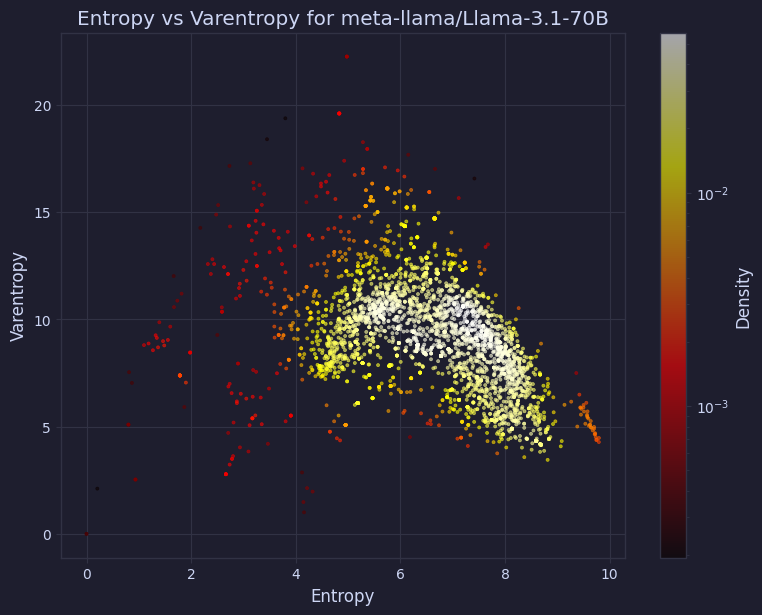

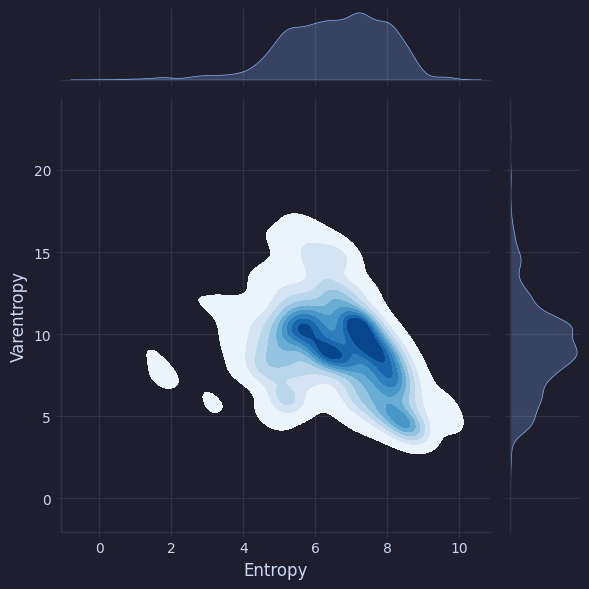

<Figure size 640x480 with 0 Axes>

2024-10-15 20:39:49,060 - INFO - Plotting 3D density for model: meta-llama/Llama-3.1-70B
/tmp/ipykernel_497070/881148481.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_base = plt.cm.get_cmap('plasma')(np.linspace(0, 1, 256))


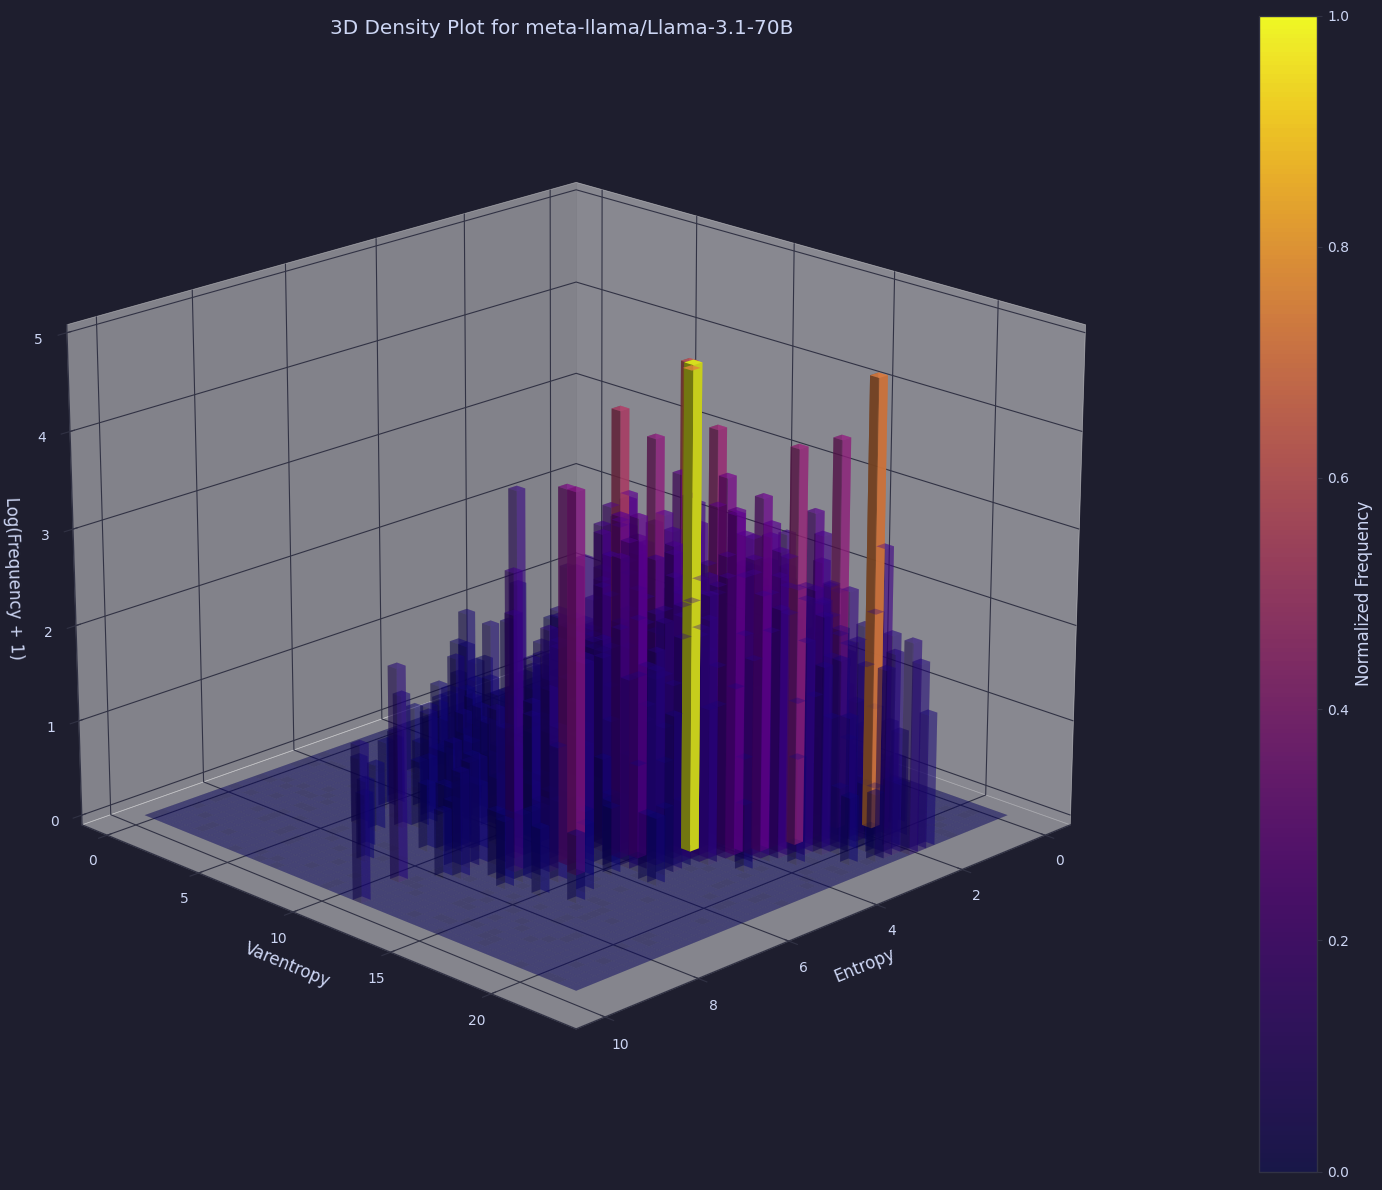

2024-10-15 20:39:49,982 - INFO - Finished processing model: meta-llama/Llama-3.1-70B
/tmp/ipykernel_497070/881148481.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_base = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 256))


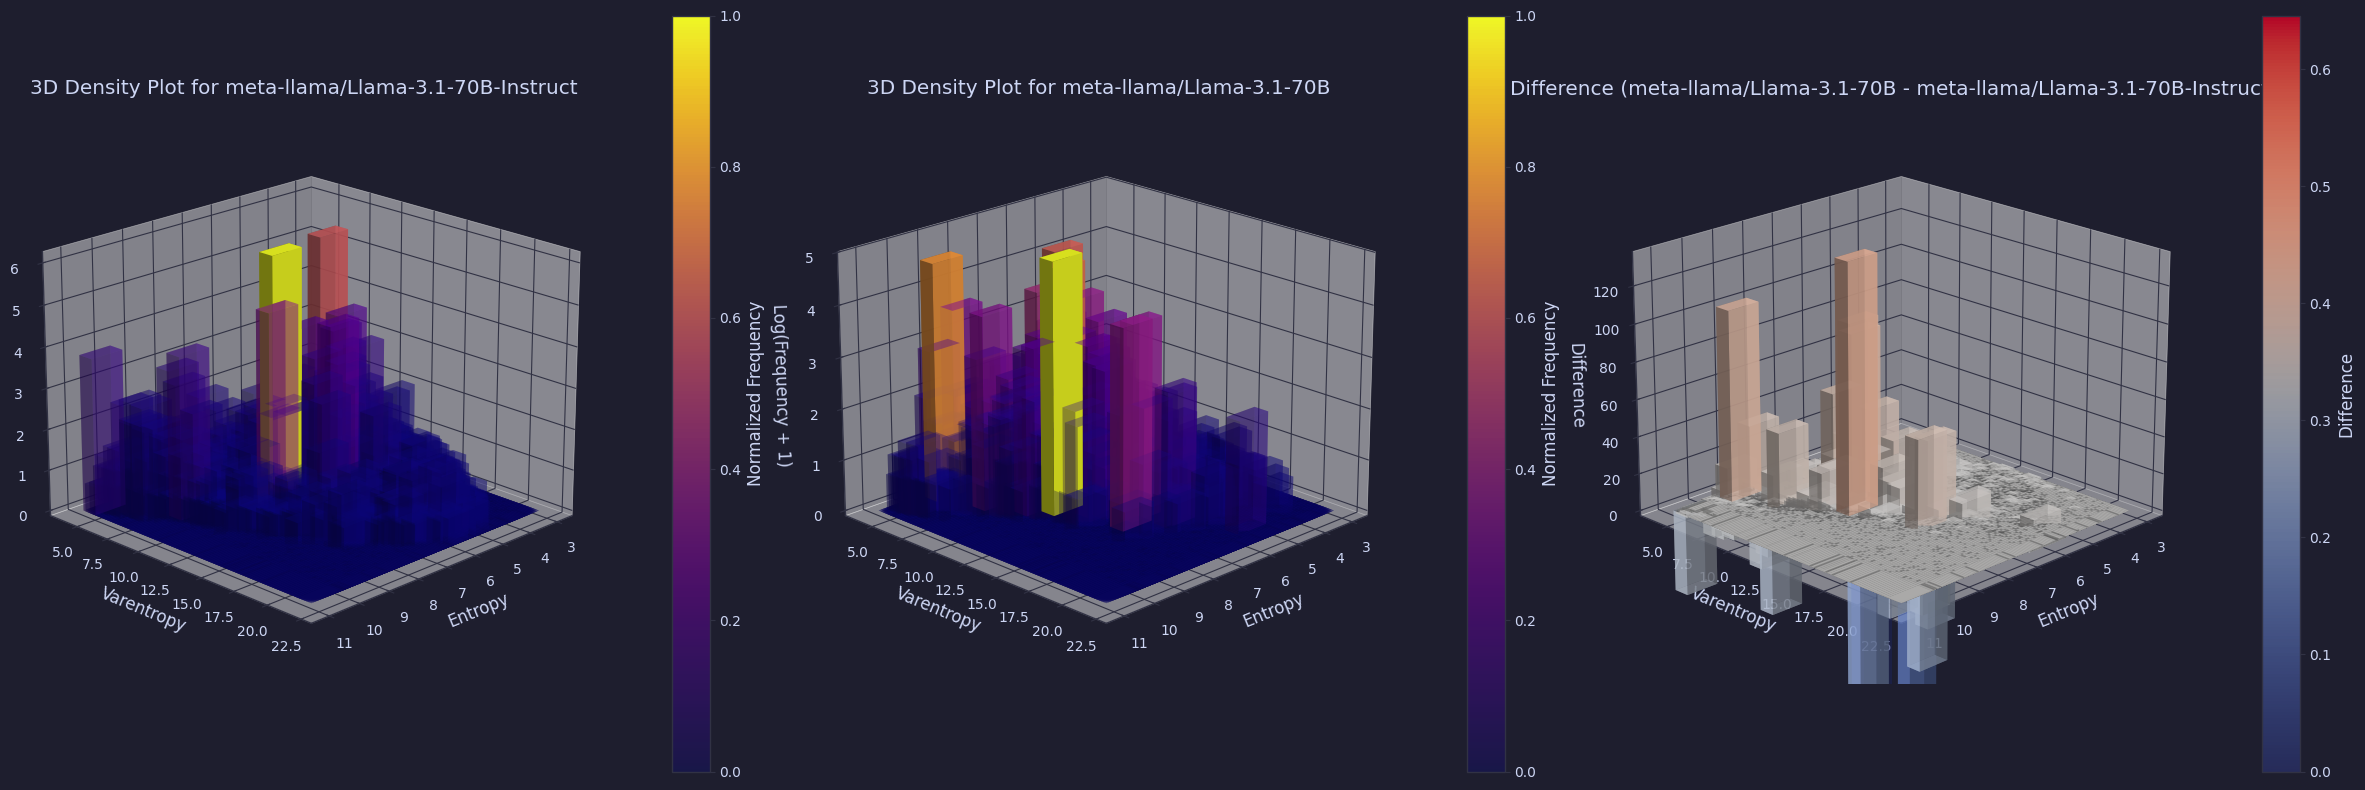

2024-10-15 20:39:57,201 - INFO - All models have been processed.


In [9]:
def main():
    # Check if CUDA is available
    if DEVICE != 'cuda':
        logger.warning("CUDA is not available. The code will run on CPU, which might be significantly slower.")

    # Download and process dataset
    prompts = download_and_process_dataset(
        dataset_name="timdettmers/openassistant-guanaco",
        text_column="text",
        num_samples=600,  # Process only 600 samples from the dataset
        num_prompts=300,  # Return 100 prompts
        min_length=100,
        max_length=150
    )
    # prompts = load_prompts(PROMPTS_CSV_PATH)

    
    # Initialize storage for all metrics
    all_metrics = {model_name: {'entropies': [], 'varentropies': []} for model_name in MODEL_NAMES}
    print(all_metrics.keys())
    
    # Process each model
    for model_name in MODEL_NAMES:
        logger.info(f"Processing model: {model_name}")

        # Load model and tokenizer
        model, tokenizer = load_model_and_tokenizer(model_name, token=HF_TOKEN)
        # model.to(DEVICE)
        # model.eval()
        # print(prompts)
        # Create batches of prompts
        # prompt_batches = [prompts[i:i + BATCH_SIZE] for i in range(0, len(prompts), BATCH_SIZE)]
        
    #     # for prompt_batch in tqdm(prompt_batches, desc=f"Processing Prompt Batches for {model_name}"):
    #     #     batch_entropies, batch_varentropies = generate_samples_and_compute_metrics(
    #     #         model=model,
    #     #         tokenizer=tokenizer,
    #     #         prompts=prompt_batch,
    #     #         num_samples=NUM_SAMPLES,
    #     #         max_new_tokens=MAX_NEW_TOKENS,
    #     #         batch_size=BATCH_SIZE,
    #     #         perturbation_scale=1e4
    #     #     )

    #     #     # Extend the metrics lists with the batch results
    #     #     all_metrics[model_name]['entropies'].extend(batch_entropies)
    #     #     all_metrics[model_name]['varentropies'].extend(batch_varentropies)

        for _ in tqdm(range(0, 8)):
            # Create the random tensor
            latent_prompt = torch.rand(4, 126, 8192).to(dtype=torch.bfloat16) * 1e6
            batch_entropies, batch_varentropies = generate_samples_and_compute_metrics(
                model=model,
                tokenizer=tokenizer,
                prompts=latent_prompt,
                num_samples=NUM_SAMPLES,
                max_new_tokens=MAX_NEW_TOKENS,
                batch_size=BATCH_SIZE,
                perturbation_scale=1e4
            )

            # Extend the metrics lists with the batch results
            all_metrics[model_name]['entropies'].extend(batch_entropies)
            all_metrics[model_name]['varentropies'].extend(batch_varentropies)

         
        entropies = all_metrics[model_name]['entropies']
        varentropies = all_metrics[model_name]['varentropies']
        
        # Plot improved metrics
        logger.info(f"Plotting metrics for model: {model_name}")
        plot_improved_metrics(
            entropies=entropies,
            varentropies=varentropies,
            model_name=model_name
        )
        
        # Plot 3D density
        logger.info(f"Plotting 3D density for model: {model_name}")
        plot_3d_density(
            entropies=entropies,
            varentropies=varentropies,
            model_name=model_name
        )

        # Clean up to free GPU memory
        del model
        del tokenizer
        torch.cuda.empty_cache()
        logger.info(f"Finished processing model: {model_name}")


    compare_3d_density(
        all_metrics[MODEL_NAMES[0]]['entropies'],
        all_metrics[MODEL_NAMES[0]]['varentropies'],
        all_metrics[MODEL_NAMES[1]]['entropies'],
        all_metrics[MODEL_NAMES[1]]['varentropies'],
        MODEL_NAMES[0],
        MODEL_NAMES[1]
    )

    
    logger.info("All models have been processed.")


if __name__ == "__main__":
    main()